# Final Assesment - Solving the Time-Indepentent Schrodinger Equation

Authored by Patrick Chin

This notebook will attempt to solve the time indepentent Schrodinger equation (TISE) numerically and compare the results to the analytic solutions.

Let us first import the required python modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import scipy.integrate as integ
import scipy.optimize as opt

Then define a few settings to determine how the notebook runs.

In [2]:
DEBUG = False

USESCIPY = True # The scipy library has many highly optimised functions
                # including a wrapper of the FORTRAN library odepack which
                # allows much faster computation of numerical integrals than
                # purely python implementation of integration techniques.
                # 
                # To use my own python functions set this to False
              
#USE_ATOMIC_UNITS = True # Not yet
                
# No interactive plots are used so inline graphs suffice
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 6 # The size of the inline plots are 
                                       # defined here.
                                       # Change these variables depending 
                                       # on your screen resolution

## The TISE

The TISE is given by 

$$ \frac{-\hbar^2}{2m} \frac{d^2\psi}{dx^2} + V(x)\psi(x) = E\psi(x) $$

where $\psi(x)$ is the wave function, $V(x)$ is the potential function, $m$ is the particle mass and $\hbar$ is Plank's constant.

To integrate this non separable equation, an implementation of the [Runge Kutta function](http://mathworld.wolfram.com/Runge-KuttaMethod.html) is used. If `USESCIPY == True` then, this function simply redirects to `scipy.integrate.odeint`. 

Note: These are both general functions that will integrate $f(x)$ between the first and last elements of $x$.

In [3]:
def RK4(f,x0,x,args=(),useodeint=True,unpack=False):
    '''Fourth-order Runge Kutta for a general differential function f
    
    Parameters
    ----------
    f : function
        Equal to the largest order in the differential equation and must 
        accept arguments `x0, x, *args`
    x0 : scalar
        Initial conditions of x and it's derivatives for Runge Kutta expansion
    x : array_like
        The x-axis (independent) values
    args : tuple
        Extra arguments to be passed into the function f
        
    Returns
    -------
    y : array_like
        An array of vectors of a similar shape to x0 coresponding to the
        value of f(x) around x0
    '''
    if useodeint:
        return integ.odeint(f,x0,x,args,mxstep=5000000) # Much faster
    
    # Appending to an array is slow - at least for stricter languages than python
    # so here I reserve space for the matrix y even though this may not speed up 
    # python at all 
    y = np.empty(shape=(np.size(x),np.size(x0)))
    
    y[0] = x0
    for i in range(1,np.size(x)):        
        h = x[i]-x[i-1] # spacing between the previous and current x point so this
                        # function does not require x points to be linearly spaced
        k1 = h*f(x0, x[i], *args)
        k2 = h*f(x0+0.5*k1, x[i]+0.5*h, *args)
        k3 = h*f(x0+0.5*k2, x[i]+0.5*h, *args)
        k4 = h*f(x0+k3, x[i]+h, *args)        
        x0 = x0 + (k1 + 2*k2 + 2*k3 + k4)/6.0
        y[i] = x0 # Other people are appending x0 to the result at the begining of
                  # the for loop. I really don't like this as on the last itteration
                  # values of k1-k4 are calculated and unused.
    if unpack:
        return zip(*y)
    return y

The functions `scipy.integrate.odeint` and our `RK4` function formula work well for first order differential equations. However for second and higher order differential equations we must use a system of first-order ODEs.



First we will rearrange the TISE to get:
$$
\frac{d^2 \psi}{dx^2 } = \frac{2m}{\hbar^2} \left[V(x) - E \right] \psi(x),
$$
Since this is a numerical calculation of a second order derivative, we are required to privide conditions for both the value of $d_x\psi$ and $d_x^2\psi$ to the integrator. So, we will define the differential of our known vector $\frac{d r}{d x}=\left[ \frac{d \psi}{d x}, \frac{d^2 \psi}{d x^2} \right]$ and pass into our differential formula to be integrated over. Hence, the integral formula will return $r=\left[ \psi, \; \frac{d \psi}{d x} \right]$. Where our solution to $\psi(x)$ is the first element of the returned vector $r$.

In [4]:
_2me_hbar2  = 2 * const.m_e / np.square(const.hbar) 

def dr_dx(r,x,V,E):
    """rhs of the second derivative of the wave function derived from the 
    schrodinger equation

    Parameters
    ----------
    r : array of shape (2,)
        where r[0] is the value of the wavefunction psi at position x
        and r[1] is the diferential of the wavefunction phi with respect 
        to position at position x
    x : scalar
        the position on the x axis being observed
    E : scalar
        the energy of the particle

    Returns
    -------
    dr_dx : array of shape (2,)
        the value of the derivatives of the wavefunction at the point(s) x
    """
    return np.array([r[1], __2me_hbar2*(V(x) - E)*r[0]])

## Helper Functions

These functions are completely independent of the task (except for the `USESCIPY` booloean)

To find the required energies that satisy the boundary conditions a root finding method is required.

Here is an implementation of the secant method. Due to failures of the secant method to converge for some functions, this will redirect to the `scipy.optimise.brentq` function; an implementation of [Brent's Method](http://mathworld.wolfram.com/BrentsMethod.html) which combines the bisection method, the secant method and inverse quadratic interpolation.

In [5]:
def find_root(f,x1,x2,args=(),xtol=1e-32,usebrentq=USESCIPY,printroot=False):
    '''Find a root of the function f(x) using the secant method.
    
    Parameters
    ----------
    x1, x2 : scalar
        The initial guess values
    tol : scalar
        Tolerance, ie maximum difference between x1 and x2 within which lies the 
        root f(x) where x1 > x > x2
    f : callable
        The function of which we want to find the root of
    args : tuple
        Extra arguments to be passed into the function f
        
    Returns
    -------
    x : scalar
        A value of x with an uncertainty less than the tolerance `tol` for which
        f(x) = 0
    '''
    if usebrentq:
        x2 = opt.brentq(f,x1,x2,args,xtol)
        if printroot:
            print("Root found at x = {:.16} where f(x)={:.16}".format(x2,f(x2,*args)))
        return x2
    
    err = x1-x2
    itt = 0
    
    while abs(err) > xtol:
        fx1 = f(x1,*args)
        fx2 = f(x2,*args)
        dfx = fx2-fx1
        
        if dfx == 0.0 or fx1 == 0.0 or fx2 == 0.0:   # div by 0 if dfx==0.0
            return x2 if abs(fx1) > abs(fx2) else x1 # return value of x that obtains the 
                                                     # closest value of f(x) to zero
                
        temp = x2 # store old closest value
        x2 -= fx2*err/dfx # secant method where x2 is now the newest approximation
        x1  = temp
        
        err = x2-x1
        itt+=1
    
    if printroot:
        print("Root found at x = {:.16}, taking {} itterations of the secant method."
              .format(x2,itt))
    
    return x2

To normalise wavefunctions, an integrating function for known values of y(x) is needed.

Here is an implementation of the trapezium rule for x points equally spaced by $h$:

$$ I(a,b) = h \left[ \frac{1}{2}f(a) + \frac{1}{2}f(b) + \sum_{k=1}^{n-1}f(x + kh) \right] $$

and unevenly spaced x points:

$$ I(a,b) = \frac{1}{2} \sum_{k=1}^{n-1}\left(x_{n+1} - x_n\right)\left(f(x_{n+1}) + f(x_n)\right) $$

In [6]:
def find_area(y,x=None,dx=1,usesimps=USESCIPY):
    """Use the trapezium or simps rule to find the area of the function y(x)
    
    Parameters
    ----------
    y : array
        Array of y(x) values
    x : array
        Array of x values coresponding to values the of y. If x==None 
        then dx is used instead
    dx : scalar
        Spacing between each y value. Only used if x==None.
    
    Returns
    -------
    I : scalar
        The area under the curve y(x)
    """
    if usesimps:
        return integ.simps(y,x,dx)
    
    if x==None:
        return dx(np.sum(y) - (y[0]+y[-1])/2.0) # (equation shown above)
    
    I = 0
    for i in range(np.size(y)-1):
        I += (x[i+1]-x[i]) * (y[i+1]+y[i]) / 2.0 # (equation shown above)
    return I

A function to detect a change in signs comes in usefull when detecting roots.

In [7]:
def sign_change(n1,n2,strict=True):
    """Return `True` if `n1` and `n2` have different signs
    If `strict==True` and `n1` or `n2` is zero, `False` is returned"""
    _n1n2 = abs(np.sign(n1)+np.sign(n2))
    return _n1n2 == 0 if strict else _n1n2 < 2 # sign(n1)+sign(n2) =    0 - sign change
                                               #                     -1,1 - contains 0
                                               #                     -2,2 - same sign

The condition for the normalisation of a wavefunction is given by:
$$ \int_{-\infty}^{\infty} \left| \psi \right|^2 \textrm{d}x = 
A\int_{-\infty}^{\infty} \left| \psi_u \right|^2 \textrm{d}x = 1$$
Where $\psi$ is the normalised wavefunction and $\psi_u$ is the unnormalised wavefunction, $A$ is the normalisation constant.

From this we get $$ \psi = \psi_u\sqrt{A} $$ where $$ \frac{1}{A} = \int_{-\infty}^{\infty} \left| \psi_u \right|^2 \textrm{d}x $$

In [8]:
def normalise_psi(psi,x):
    """Normalise the wavefunction psi(x)"""
    return psi / np.sqrt(find_area(np.square(psi),x))

## The Quantum System Class

I prefer to keep the coding and the physics to be separate. Here is a class that numerically solves the schrodinger equation for energy states that satisfy the equation `ef(E)==0`. In this case, `ef` returns the value of $\psi$ at the last position in the `x` array, meaning the roots of this function are energy states $E_N$ that fit the boundary condition that $\psi$ must be 0 at the boundary.

This is a long class but bear with me. :)

In [9]:
class qmsys1d(object):
    """
    A slightly general class to calculate the possible wavefunctions of a single 
    quantum mechanical particle in one dimension.
    
    Solve an equation system :math:`y'(t) = f(t,y)` with (optional) ``jac = df/dy``.
    
    Parameters
    ----------
    x : array
        List of x coords for which the wavefunction (:math:`psi`) is calculated
    V : callable ``V(x)``
        Potential of the system at point x, where x is a scalar.
        `V` should return a scalar.
    r0 : array 
        ``r0.shape==(2,)``. The initial value of `r = [psi, psi']`.
    EN : scalar
        Number of allowed energy states to calculate
    Eh : scalar
        Minimum spacing between allowed energy values
    El : scalar
        Lower bound to start searching for energy states
    Etol : scalar
        Tollerence used when finding roots for the energy
    store_ef_values : boolean
        Whether or not to store values of teh energy picking function which can 
        be plotted
    
    Attributes
    ----------
    E : array
        List of energy states
    psi : array
        List of psi values each of which coerespond to and energy level in `E`
    psi2 : array
        List of psi^2 values i.e. the probability density values
    """
    
    def __init__(self,x,V,r0,EN=4,Eh=1e-18,El=0.0,Etol=1e-32,store_ef_values=False):        
        self.x = x
        self.V_ = V
        self.r0 = r0
        
        self._rem_ef = store_ef_values
        if store_ef_values:
            self.efE = []    # init energy picking function energies
            self.efval = []  # init energy picking function y values
            
        self.psi   = []
        self.psi2  = []
        
        self.E = []
        self.Eh = Eh
        self.El = El
        self.Etol = Etol
     
        self.find_energies_upto(EN)

    def ef(self,E):
        return self.calculate_psi(E,False)[-1]
    
    def find_energies_upto(self,n):
        """Simply runs `find_next_energy` until energy level of up to n is found"""
        l = len(self.E)
        if n < l: return # if already calculated
        for i in range(n-l+1):
            self.find_next_energy()        
    
    def find_next_energy(self):
        """In steps of Eh increase the energy and if there is a sign change in the 
        function `ef(currE)` and `ef(currE+Eh)`
        """
        found = False
        currE = self.El if len(self.E)==0 else self.E[-1] + self.Eh # check if first run
        
        while not found:            
            prevE = currE
            currE += self.Eh
            prevPsi = self.ef(prevE) # 
            currPsi = self.ef(currE)
                        
            if self._rem_ef: 
                # store energy picking function values to be plotted
                # (not part of the find energy algorithm)
                if len(self.E)==0:
                    self.efE.append(prevE) #
                    self.efval.append(prevPsi)
                self.efE.append(currE)
                self.efval.append(currPsi)
            
            if sign_change(prevPsi,currPsi): # root?
                found = True
                root = find_root(self.ef, prevE, currE, xtol=self.Etol) # find root of ef between prevE and currE
                psi = normalise_psi(self.calculate_psi(root),self.x) # calculate and normalise psi
                
                self.E.append(root)
                self.psi .append(psi)
                self.psi2.append(np.square(psi))

        return root
    
    def calculate_psi(self,E,keepr=False):
        """Calculate the wavefunction for a given energy E"""
        psi = RK4(self.d2psi,self.r0,self.x,(E,))
        if keepr: return psi
        return psi[:,0]
        
    def V(self,x):
        """Return the potential(s) at x"""
        if np.isscalar(x):
            return self.V_(x)
        return [self.V(xi) for xi in x]
    
    _2me_hbar2  = 2 * const.m_e / np.square(const.hbar)
    def d2psi(self,r,x,E):
        """Rhs of the schrodinger equation in the form `psi'' = d2psi(x,psi)`"""
        return np.array([r[1], qmsys1d._2me_hbar2*(self.V(x) - E)*r[0]])
    
    def plotef(self):
        """Plot the function from which the energies En are derived where 
        ``ef(En,self)==0`` is an energy level"""
        if not self._rem_ef: return
        
        plt.axhline(y=0,c='k',ls='--',lw=1)
        plt.plot(self.efE,self.efval)
                
        plt.title("Plot of the energy picker function")
        plt.xlabel("Energies $E$ / J")
        plt.ylabel("$ef(E)$")
        plt.grid(True)
        plt.show()
    
    def plot(self,n,show=True):
        """Plot the wavefunction of energy level n"""
        #n -= 1
        if n < 0 or n >= len(self.psi): 
            print("Energy state {} has not yet been calculated.".format(n))
            print("Please enter an energy level between 1 and {} or run find_energies_upto({})".format(len(self.psi),n))
            return
        
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()

        ax1.plot(self.x,self.psi[n],'b')
        ax1.grid(True)
        ax1.set_ylabel("$\psi$") 
        ax1.set_xlabel("$x$") 

        ax2.axvline(x= a,c='k',ls=':',lw=1)
        ax2.axvline(x=-a,c='k',ls=':',lw=1)

        ax2.plot(self.x,self.V(self.x),'k--')
        ax2.plot([self.x[0],self.x[-1]],[self.E[n],self.E[n]],'r--')
        ax2.get_yaxis().set_visible(False)


        ax3.plot(0,0,'k--',label="$V$")          
        ax3.plot(0,0,'r--',label="$E$")
        ax3.plot(0,0,'b',label="$\psi$")  
        ax3.plot(self.x,self.psi2[n],'g',label="$|\psi^2|$")  

        ax3.set_ylabel("Probability Density")     
        ax3.legend()

        plt.title("Particle in the with energy $E_{}$".format(n))
        plt.show()
        
    def plotall(self):
        """Plot all calculated wavefunctions on seperate plots"""
        for n in range(0,len(self.psi)):
            self.plot(n+1)

## Constants

In [10]:
V0 = 800 * const.e
a  = 5.0e-11 # Half the width of the potential well

<div class="alert alert-success">
    Uncomment cells bellow to display the graphs.
</div>

## Infinite Square Well

Despite the notation of the ground state of the infinite square well relating to n=1, here the n=0 energy state relates to the ground state. This is so teh class `qmsys1d` remains the same for other potential systems, i.e. the harmonic potential has a ground state at n=0.

In [11]:
# is - infinite square
issystem = qmsys1d(np.linspace(-a, a, 1000),   # x values
                             lambda x: 0.0,    # function calculating the potential at position x
                             [0.0,1.0],        # initial condition of psi and dpsi/dx
                             5,                # number of energy states to calculate
                             2e-18,            # search energy steps
                             store_ef_values=True,
                             )

Energy states of the infinite square well can be found by solving the schrodinger question algebraically
$$
E_n = \frac{\pi^2 \hbar^2 n^2}{2m (2a)^2}
$$
The function define here returns this value

In [12]:
def isEn(n): 
    """Theoretical infinite square well energy levels"""
    return np.square(np.pi*const.hbar*n) / (8*const.m_e*np.square(a))

In [13]:
#[isEn(i) for i in range(1,6)] # First 5 energy states for the infinite square well calculated using the theoretical equation

In [14]:
#issystem.E # Energy states calculated from finding the roots of the ef() function)

In [15]:
#issystem.plotef()

In [16]:
#issystem.plot(0) # change number here to display specific energy states

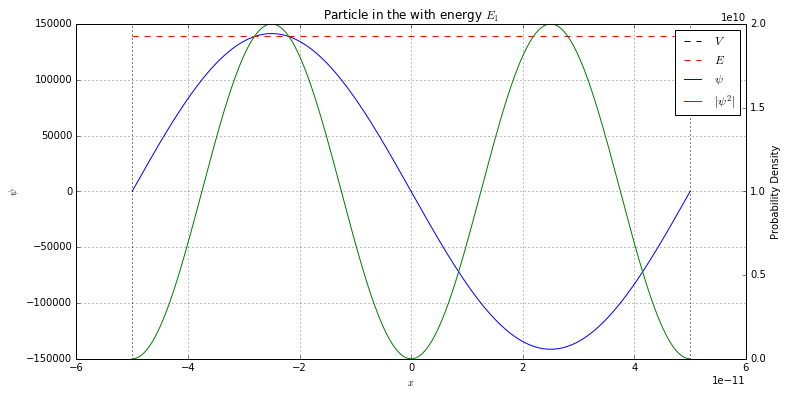

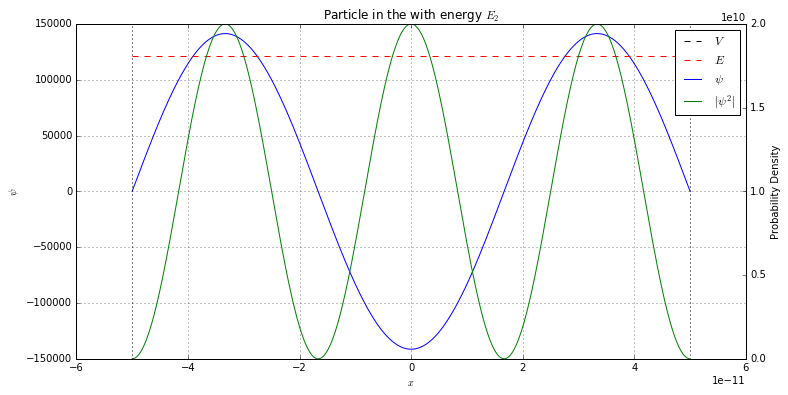

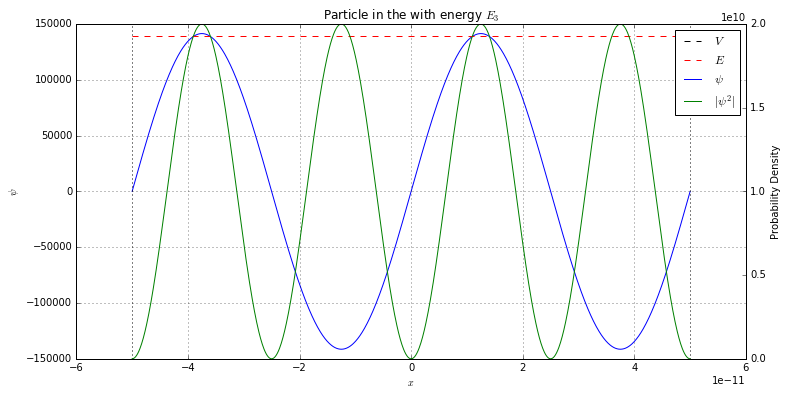

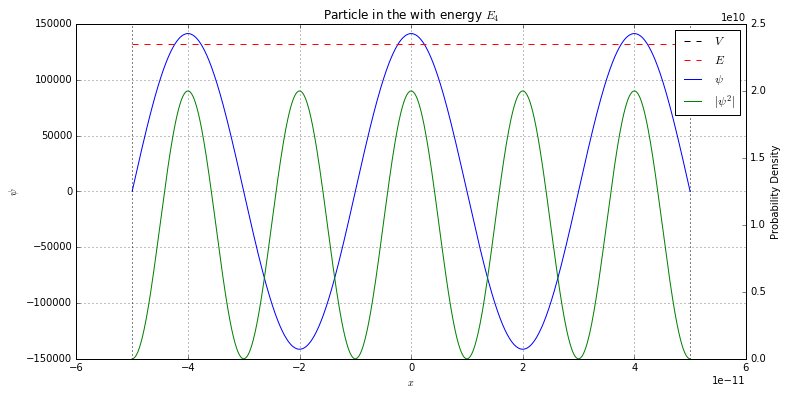

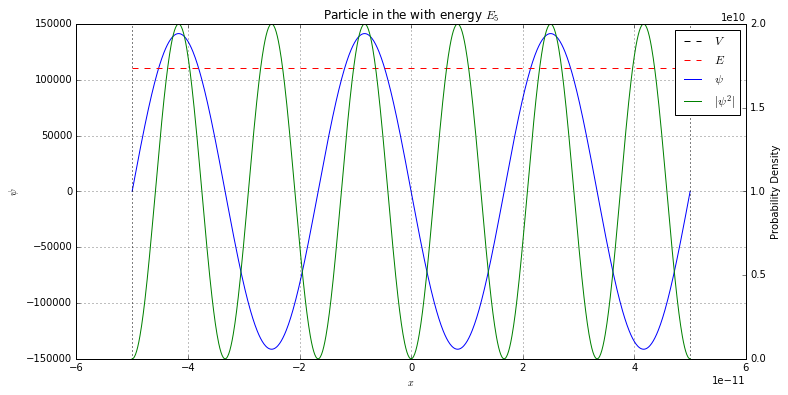

Energy state 6 has not yet been calculated.
Please enter an energy level between 1 and 6 or run find_energies_upto(6)


In [17]:
issystem.plotall()

### Comparing theoretically solved and numerically solved wavefunctions $\psi$

Here is simply a loop going throught the wavefunctions stored in our `issystem` and plots them against the the theoretical wavefunctions

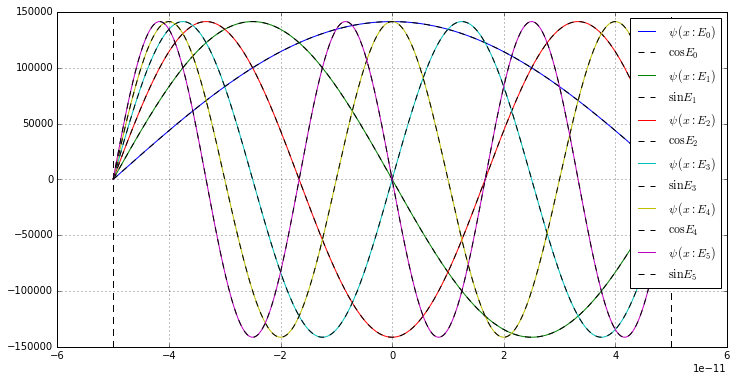

In [18]:
colours = ['b','g','r','c','y','m'] # teh colour cycle

for n in range(len(issystem.psi)):
        
    # potential barrier lines
    plt.axvline(x= a,c='k',ls='--',lw=1)
    plt.axvline(x=-a,c='k',ls='--',lw=1)
    
    # calculated wavefunctions
    plt.plot(issystem.x,issystem.psi[n],colours[n%6],label="$\psi\,(x:E_{})$".format(n))
    
    # theoretical solutions for the infinite ground state
    sincos = np.sin if n & 0x1 else np.cos  # sin if odd, cos if even
    sincostxt = "sin" if n & 0x1 else "cos"
    plt.plot(issystem.x,
             #
             # n+1 is used so the n=0 (as opposed to the n=1) will return the ground state
             #
             # To fit our initial condition that psi = 0 at x = -a and dpsi_dx > 0 at x = -a
             # we need to add a phase difference.
             #
             # This was done mainly through trial and error
             # The observation:
             # for n = 1, 2, 3, 4, 5, 6, 7, 8, 9
             # the n =    2, 3,       6, 7,      states were pi phase shifted
             #
             # The solution
             # the function (n//2) will map n to:
             #  n//2 = 0, 1, 1, 2, 2, 3, 3, 4, 4
             # from this we can add a phase shift of (n//2)*pi which will leave even
             # values of n//2 alone while odd values will get shifted by pi
             #
             # The modulus 2 of this result it taken simply for peace of mind,
             # so we only add up to 1*pi phase shift
             #
             sincos((n+1)*np.pi*issystem.x/2.0/a + np.pi*(((n+1)//2)%2))/np.sqrt(a),
             'k--',label="$\{} E_{}$".format(sincostxt,n))
        
    
plt.grid(True)
plt.legend()
plt.show()

In [19]:
#issystem.find_energies_upto(20)
#issystem.plot(20)

## Infinite Harmonic Well

In [20]:
# ih - infinite harmonic
ihsystem = qmsys1d(np.linspace(-a, a, 1000),   # x values
                   lambda x: V0 * np.square(x/a) if abs(x) <= a else 0.0,    # function calculating the potential at position x
                   [0.0,1.0],                  # initial condition of psi and dpsi/dx
                   5,                          # number of energy states to calculate
                   4e-18,                      # search energy steps
                   store_ef_values=True,      
                   )

In [21]:
def ihEn(n): # this does not curretnly work
    """Theoretical infinite harmonic well energy levels
    
    I am unsure about how t oget the theoretical values of energy for the infinite harmonic potential
    """
    return (n+0.5)*const.hbar*np.square(np.pi*const.c/const.m_e/a)

In [22]:
#[ihEn(i) for i in range(1,6)] # First 5 energy states for the infinite square well calculated using the theoretical equation

In [23]:
ihsystem.E

[1.7761329310535968e-17,
 5.392991556758462e-17,
 9.300067075913331e-17,
 1.3854118206401133e-16,
 1.9370684985730497e-16,
 2.601448367929945e-16]

In [24]:
#ihsystem.plotef()

In [25]:
#ihsystem.plot(2) # change number here to display specific energy states

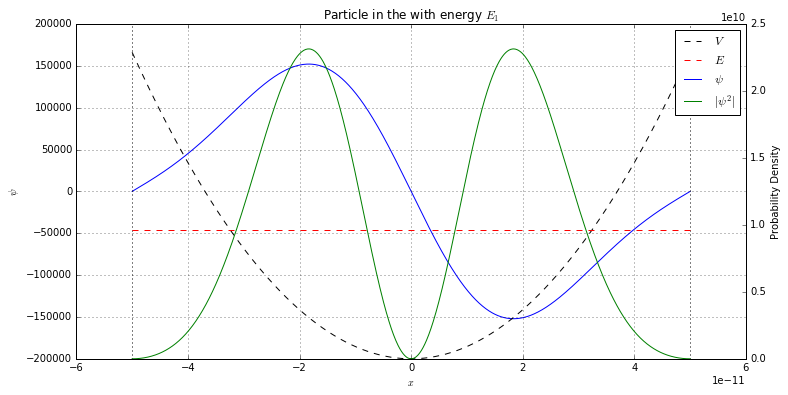

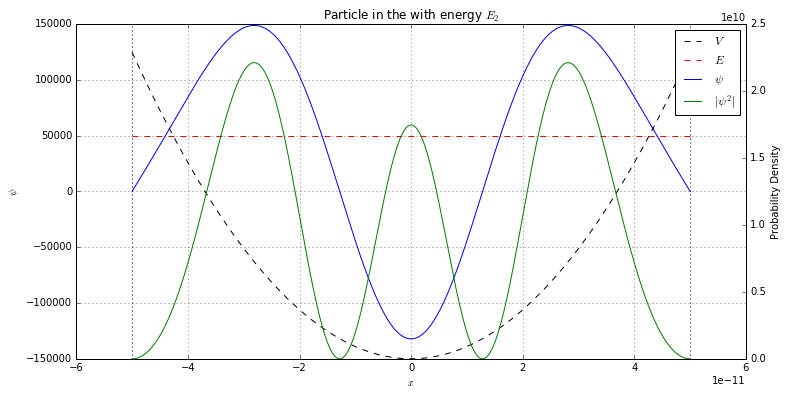

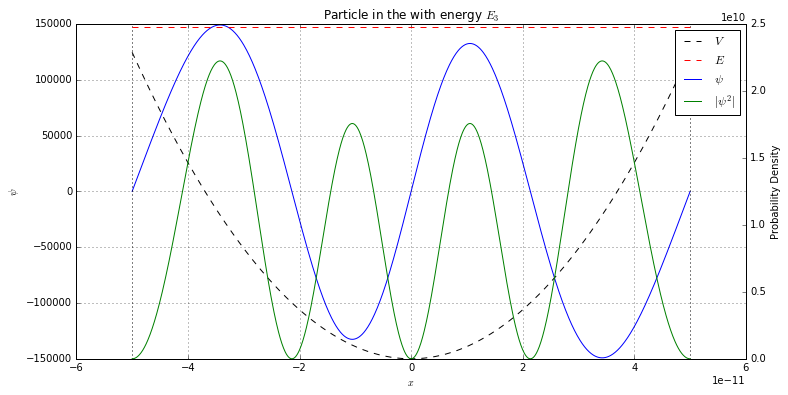

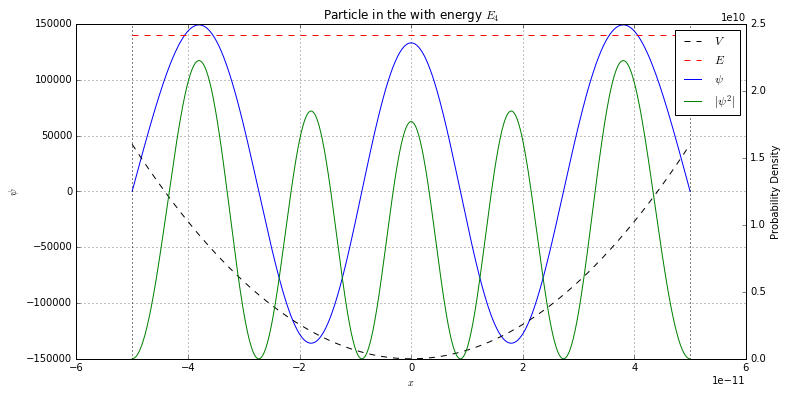

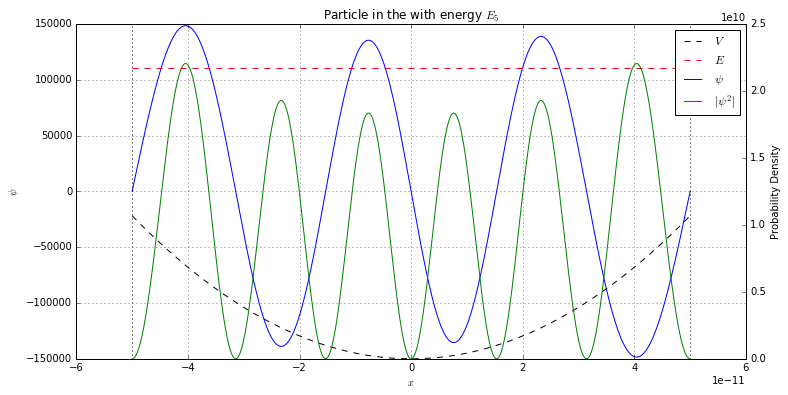

Energy state 6 has not yet been calculated.
Please enter an energy level between 1 and 6 or run find_energies_upto(6)


In [26]:
ihsystem.plotall()

## Finite Square Well

In [27]:
# fs - finite square
fssystem = qmsys1d(np.linspace(-a, a, 1000),
                   lambda x: 0.0 if abs(x) <= a/2.0 else V0,
                   [0.0,1.0],3,1e-17,store_ef_values=True) # Refer to class definition for explination 

In [28]:
#fssystem.E

In [29]:
#fssystem.plotef()

In [30]:
#fssystem.plot(2) # change number here to display specific energy states

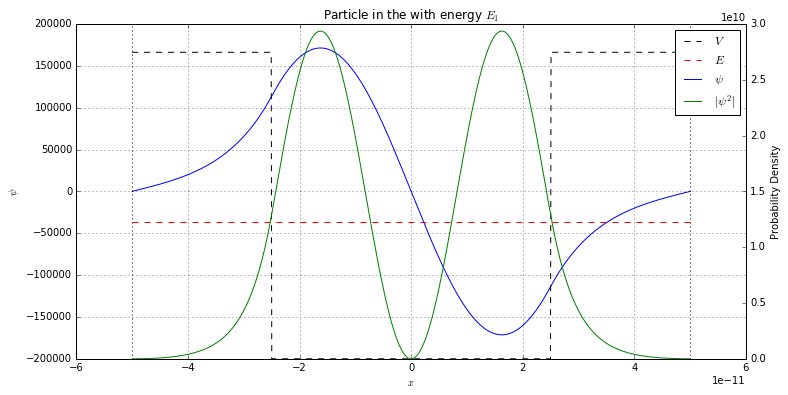

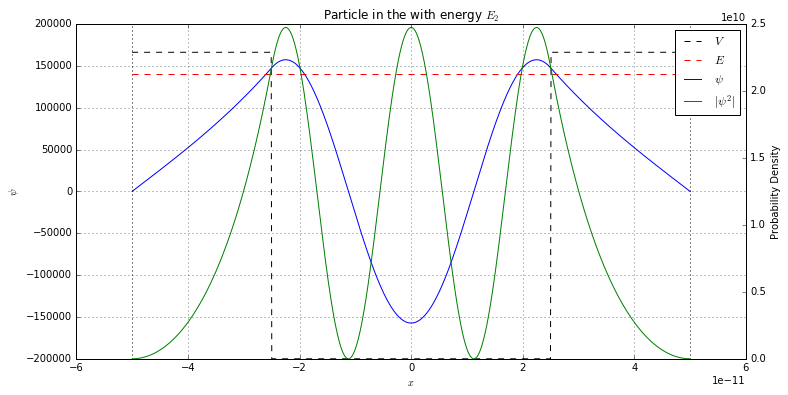

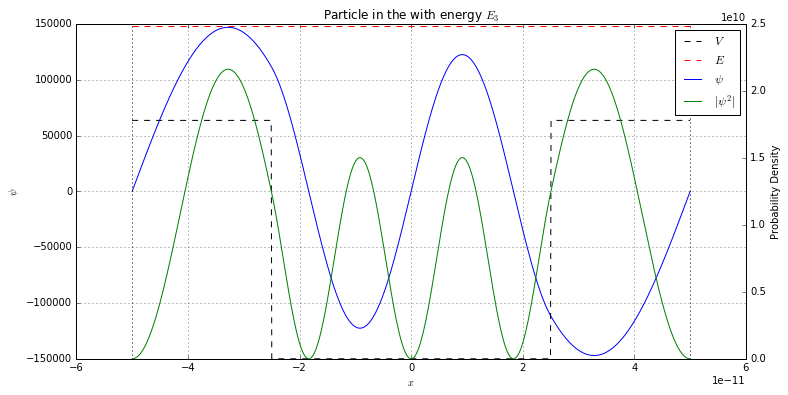

Energy state 4 has not yet been calculated.
Please enter an energy level between 1 and 4 or run find_energies_upto(4)


In [31]:
fssystem.plotall()

## Finite Harmonic Well

In [32]:
# fh - finite harmonic
fhsystem = qmsys1d(np.linspace(-a, a, 1000),
                   lambda x: V0 * np.square(x/a) if abs(x) <= a else V0,
                   [0.0,1.0],4,store_ef_values=True)

In [33]:
#fhsystem.E

In [34]:
#fhsystem.plotef()

In [35]:
#fhsystem.plot(2) # change number here to display specific energy states

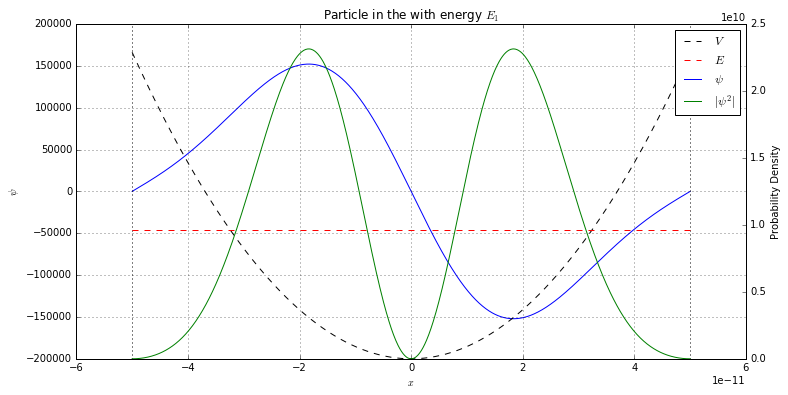

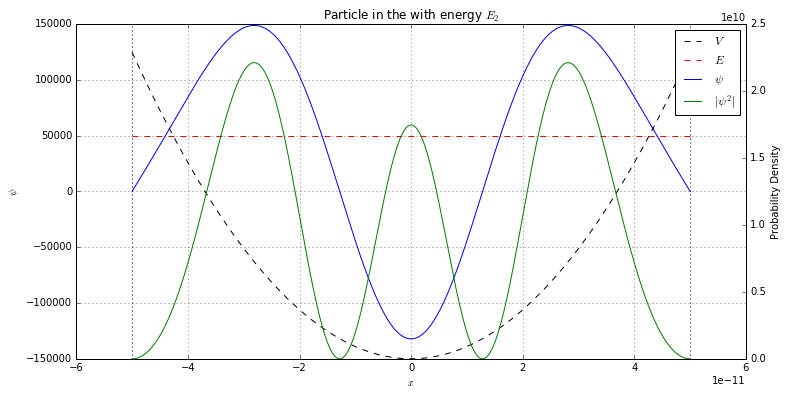

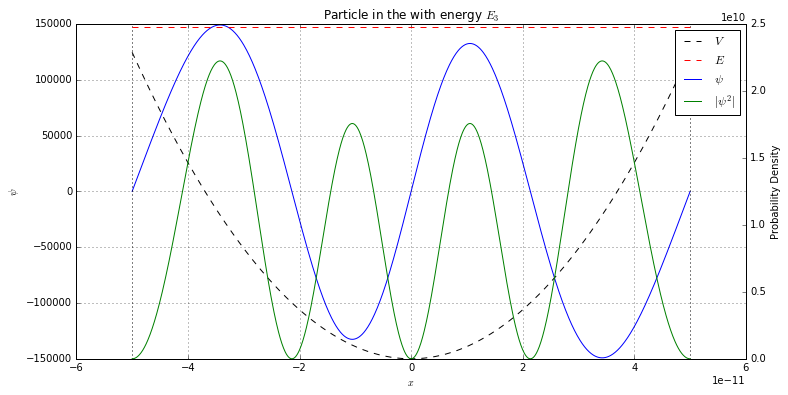

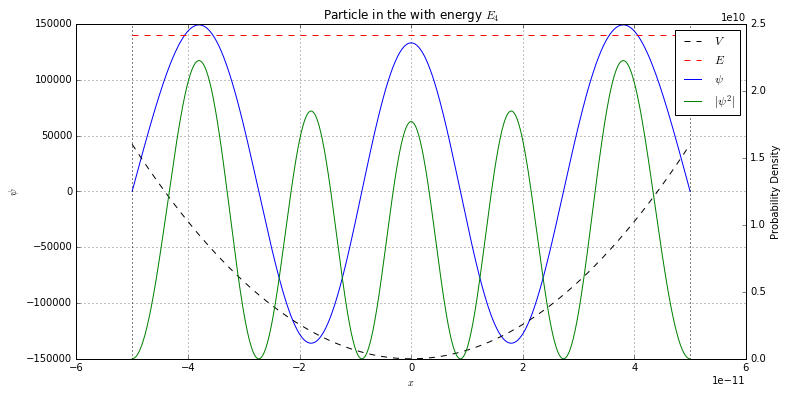

Energy state 5 has not yet been calculated.
Please enter an energy level between 1 and 5 or run find_energies_upto(5)


In [36]:
fhsystem.plotall()

## Finite Square Barrier

In [37]:
# fhb - finite harmonic barrier
fhbsystem = qmsys1d(np.linspace(-a, a, 1000),
                    lambda x: V0 if abs(x) <= a/5 else 0.0,
                    [0.0,1.0],4,El=0,store_ef_values=True)

In [38]:
#fhbsystem.E

In [39]:
#fhbsystem.plotef()

In [40]:
#fhbsystem.plot(2) # change number here to display specific energy states

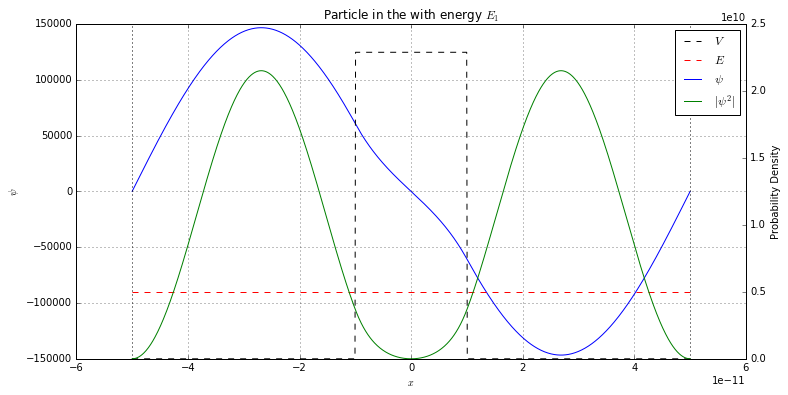

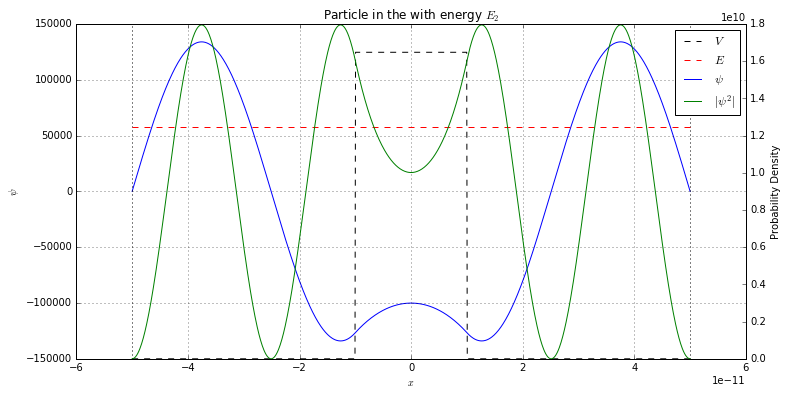

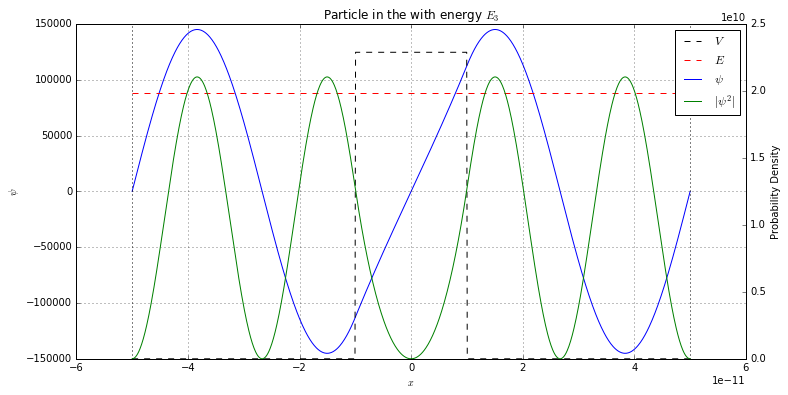

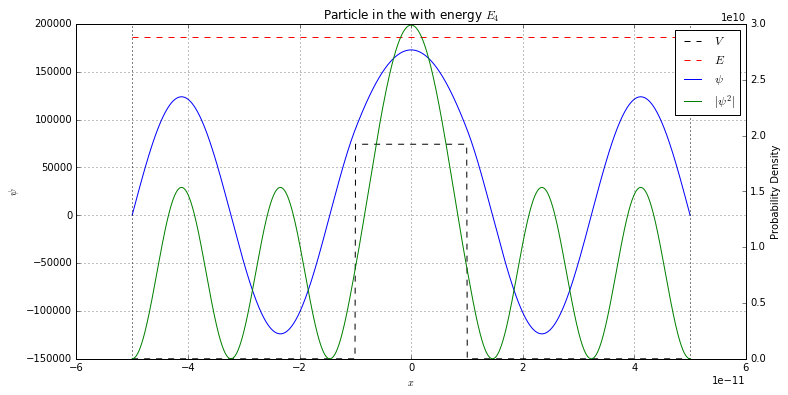

Energy state 5 has not yet been calculated.
Please enter an energy level between 1 and 5 or run find_energies_upto(5)


In [41]:
fhbsystem.plotall()

# Finite Harmonic Barrier

In [42]:
asystem = qmsys1d(np.linspace(-a, a, 1000),
                    lambda x: V0*(1 - np.square(4*x/a)) if abs(x) <= a/4 else 0.0,
                    [0.0,1.0],4,El=0,store_ef_values=True)

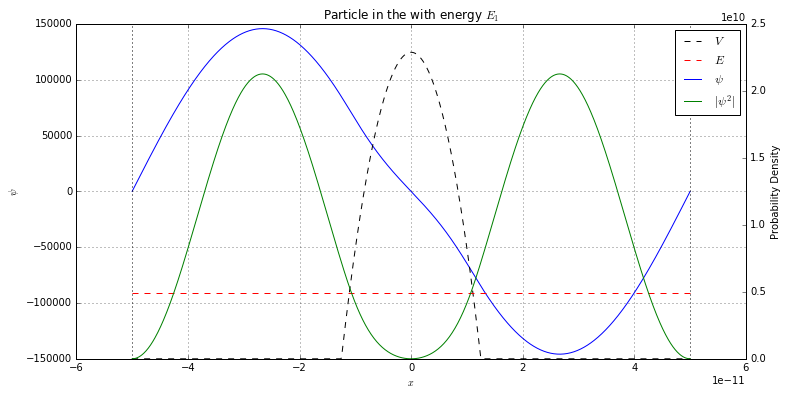

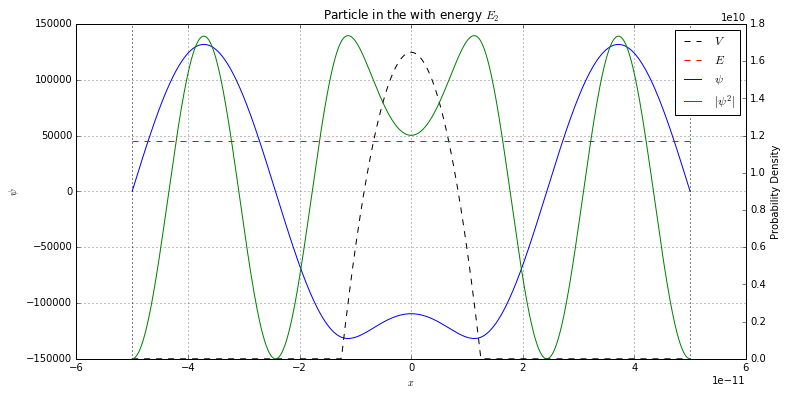

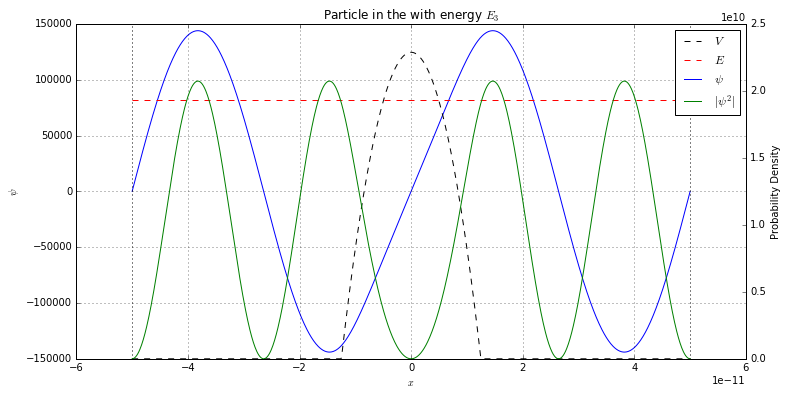

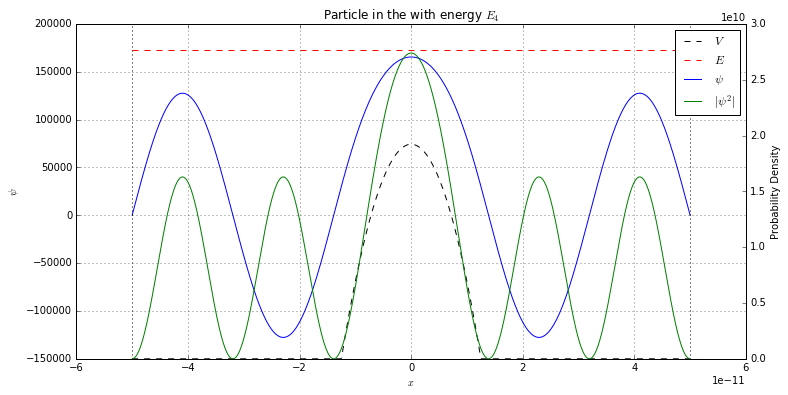

Energy state 5 has not yet been calculated.
Please enter an energy level between 1 and 5 or run find_energies_upto(5)


In [43]:
asystem.plotall()

# General Observations

When the energy `E` is larger than the `V0` the particle will act as a free particle and so the wavefunction will produce a sine graph. When this happened the probability of the particle being within the well is reduced which is counter intuitive.